In [1]:
import pandas as pd
import numpy as np
import os

os.chdir("/Users/Nate/Desktop/Sustento")

# Import simulation data
simdat = pd.read_csv("MidPackage_RetrofitResults.csv")
# Import HVAC data
hvac = pd.read_csv("LA_HVAC_results.csv")
print('Pre-merge:','\n',simdat.shape, '\n', hvac.shape)

# Merge dataframes
merged = pd.merge(simdat, hvac, left_on="building id", right_on="citybes_id")
print("Post-merge:","\n", merged.shape)
merged.head()


Pre-merge: 
 (486, 105) 
 (243, 5)
Post-merge: 
 (486, 110)


,building id,building name,user defined building id,ubid,building type,year built (year),height (m),number of stories,total floor area (m2),baseline annual site energy use intensity (kWh/m2),...,Applicable ECM name 18,Applicable ECM ID 19,Applicable ECM name 19,Applicable ECM ID 20,Applicable ECM name 20,citybes_id,LA_bid,HVAC_system_type,number_of_HVAC_units,average_cooling_capacity_per_HVAC_unit(kW)
0,7622814,NaN,NaN,3.905750e+11,Large Office,1984,9.34,3,22656.0624,185.8748,...,NaN,NaN,NaN,NaN,NaN,7622814,390574910969,central chiller + boiler (VAV with reheat),1,2076.961865
1,7622814,NaN,NaN,3.905750e+11,Large Office,1984,9.34,3,22656.0624,185.8748,...,NaN,NaN,NaN,NaN,NaN,7622814,390574910969,central chiller + boiler (VAV with reheat),1,2076.961865
2,7622813,NaN,NaN,4.967960e+11,Multi Family House,1971,13.71,4,5214.8184,100.9181,...,NaN,NaN,NaN,NaN,NaN,7622813,496795871774,split system air conditioner+gas furnace - eac...,48,4.762106
3,7622813,NaN,NaN,4.967960e+11,Multi Family House,1971,13.71,4,5214.8184,100.9181,...,NaN,NaN,NaN,NaN,NaN,7622813,496795871774,split system air conditioner+gas furnace - eac...,48,4.762106
4,7622824,NaN,NaN,3.785630e+11,Large Office,1981,14.74,5,10631.4600,197.9038,...,NaN,NaN,NaN,NaN,NaN,7622824,378562887758,central chiller + boiler (VAV with reheat),1,1240.109131


In [2]:
import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

In [3]:
# Renaming variables
merged = merged.rename(columns={"year built (year)": "year_built", 
                                "total floor area (m2)": "floor_area", 
                                "baseline annual site energy use intensity (kWh/m2)": "site_eui",
                                "baseline annual water for water systems (m3/m2)": "annual_water",
                               "baseline annual natural gas use intensity (kWh/m2)": "annual_gas"})

# Changing units
merged["annual_water"] = merged["annual_water"]*merged["floor_area"]
merged["annual_gas"] = (merged["annual_gas"]*merged["floor_area"])/29.3
merged["annual_water"] = merged["annual_water"]*264.172
merged["floor_area"] = merged["floor_area"]*10.7639
merged["annual_water"]=merged["annual_water"]/merged["floor_area"]

In [4]:
merged["annual_gas"]

0      3447.510383
1      3447.510383
2      7035.626528
3      7035.626528
4      2460.185157
          ...     
481     943.057005
482    1112.015651
483    1112.015651
484    1016.485995
485    1016.485995
Name: annual_gas, Length: 486, dtype: float64

In [5]:
# Adding year_built indicators
merged["post1980"] = 0
merged.loc[(merged['year_built'] >= 1980), 'post1980'] = 1

# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(merged[["floor_area","site_eui","annual_water"]])
merged[["floor_area","site_eui","annual_water"]] = scaler.transform(merged[["floor_area","site_eui","annual_water"]])
merged["annual_gas"]

0      3447.510383
1      3447.510383
2      7035.626528
3      7035.626528
4      2460.185157
          ...     
481     943.057005
482    1112.015651
483    1112.015651
484    1016.485995
485    1016.485995
Name: annual_gas, Length: 486, dtype: float64

In [6]:
merged.head()

,building id,building name,user defined building id,ubid,building type,year_built,height (m),number of stories,floor_area,site_eui,...,Applicable ECM ID 19,Applicable ECM name 19,Applicable ECM ID 20,Applicable ECM name 20,citybes_id,LA_bid,HVAC_system_type,number_of_HVAC_units,average_cooling_capacity_per_HVAC_unit(kW),post1980
0,7622814,NaN,NaN,3.905750e+11,Large Office,1984,9.34,3,0.130515,0.437533,...,NaN,NaN,NaN,NaN,7622814,390574910969,central chiller + boiler (VAV with reheat),1,2076.961865,1
1,7622814,NaN,NaN,3.905750e+11,Large Office,1984,9.34,3,0.130515,0.437533,...,NaN,NaN,NaN,NaN,7622814,390574910969,central chiller + boiler (VAV with reheat),1,2076.961865,1
2,7622813,NaN,NaN,4.967960e+11,Multi Family House,1971,13.71,4,0.028289,0.134163,...,NaN,NaN,NaN,NaN,7622813,496795871774,split system air conditioner+gas furnace - eac...,48,4.762106,0
3,7622813,NaN,NaN,4.967960e+11,Multi Family House,1971,13.71,4,0.028289,0.134163,...,NaN,NaN,NaN,NaN,7622813,496795871774,split system air conditioner+gas furnace - eac...,48,4.762106,0
4,7622824,NaN,NaN,3.785630e+11,Large Office,1981,14.74,5,0.060037,0.480487,...,NaN,NaN,NaN,NaN,7622824,378562887758,central chiller + boiler (VAV with reheat),1,1240.109131,1


In [7]:
# Selecting only buidlings from Simulation
merged = merged[merged['retrofit package name'] == "ECM Package 1"]

# Selecting only relevant rows
merged_mfh = merged[merged["building type"] == "Multi Family House"]
merged_off = merged[merged["building type"].isin(['Medium Office', 'Small Office', "Large Office"])]
merged_ret = merged[merged["building type"].isin(["Medium Retail", 'Small Retail'])]
merged_ret.shape

(8, 111)

In [8]:
merged_mfh["annual_gas"]

3       7035.626528
9       7063.179532
11      8536.918548
23      4315.745190
25      1860.606076
           ...     
467     9133.527571
469    24971.626976
475     7268.323983
477    11015.961198
479    10246.341615
Name: annual_gas, Length: 118, dtype: float64

In [9]:
# Regression model
res_mfh = smf.ols('annual_gas ~ floor_area + np.power(floor_area,2) + post1980 + site_eui + annual_water-1', data=merged_mfh).fit()
res_off = smf.ols('annual_gas ~ floor_area + np.power(floor_area,2) +  site_eui-1', data=merged_off).fit()
res_ret = smf.ols('annual_gas ~ floor_area + np.power(floor_area,2) + post1980 + site_eui + annual_water-1', data=merged_ret).fit()
print(res_off.summary())

                                 OLS Regression Results                                
Dep. Variable:             annual_gas   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.871
Method:                 Least Squares   F-statistic:                              263.6
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                    4.19e-51
Time:                        11:36:50   Log-Likelihood:                         -1182.8
No. Observations:                 117   AIC:                                      2372.
Df Residuals:                     114   BIC:                                      2380.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Adjusted R squarted for each regression:
- Multifamily house: 0.994
- Medium and Small Offices: 0.855
- Large Offices: 0.916
- Medium and Small Retail: 0.903

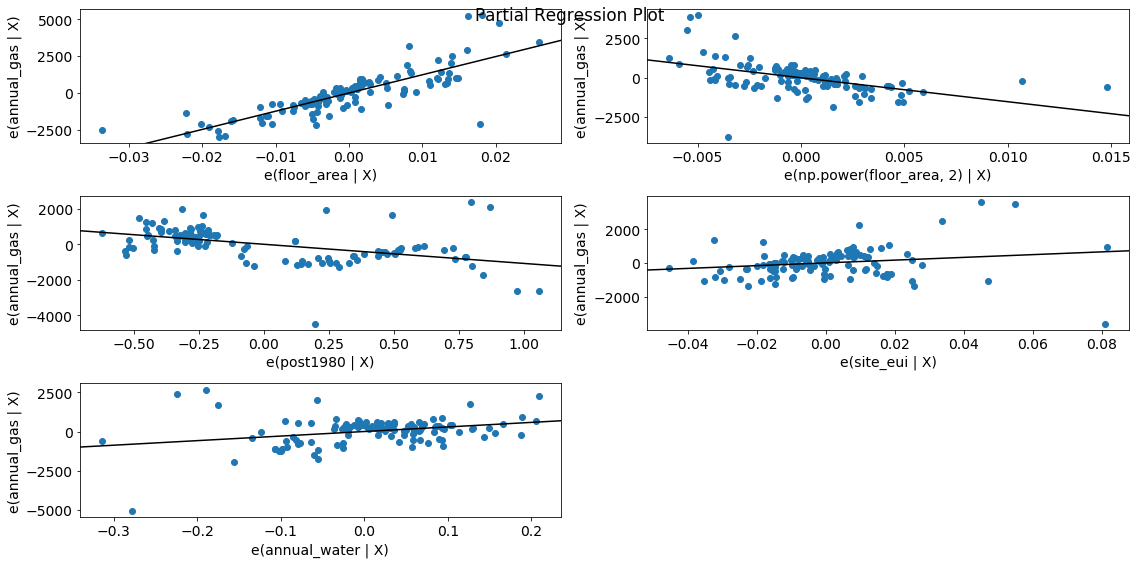

In [10]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res_mfh)
fig.tight_layout(pad=1.0)

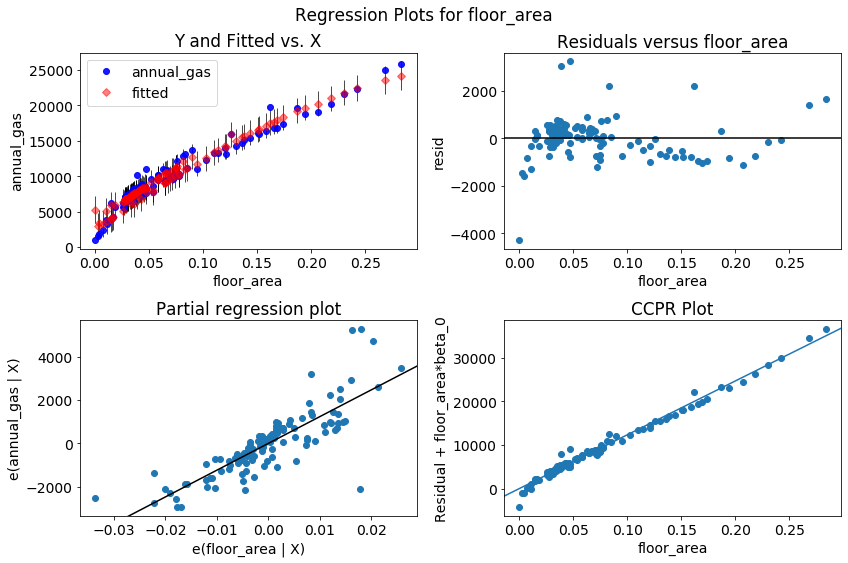

In [11]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(res_mfh, 'floor_area', fig=fig)

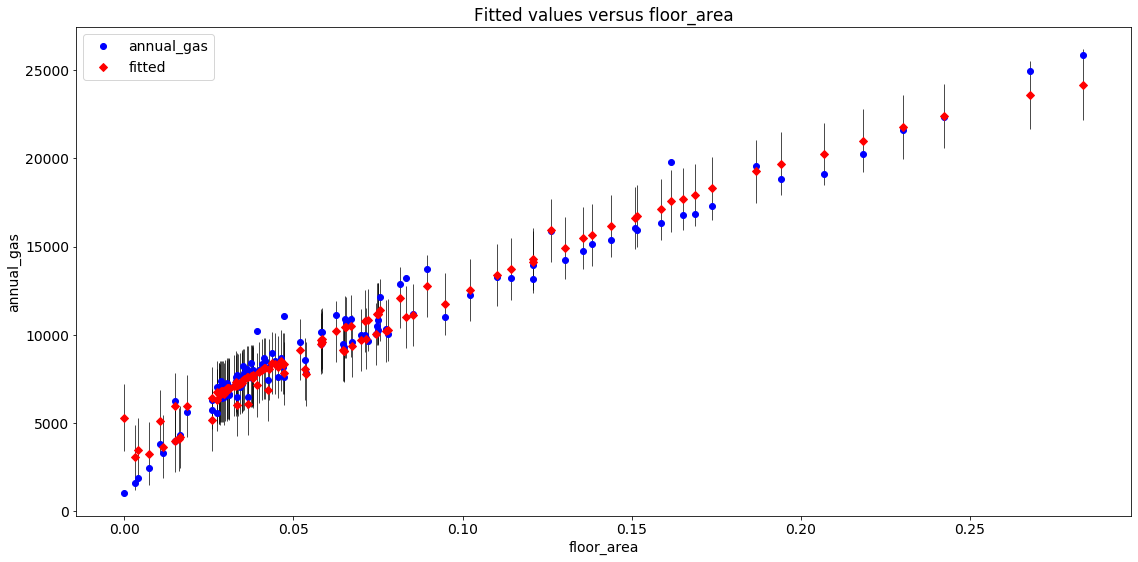

In [12]:
fig = sm.graphics.plot_fit(res_mfh, "floor_area")
fig.tight_layout(pad=1.0)

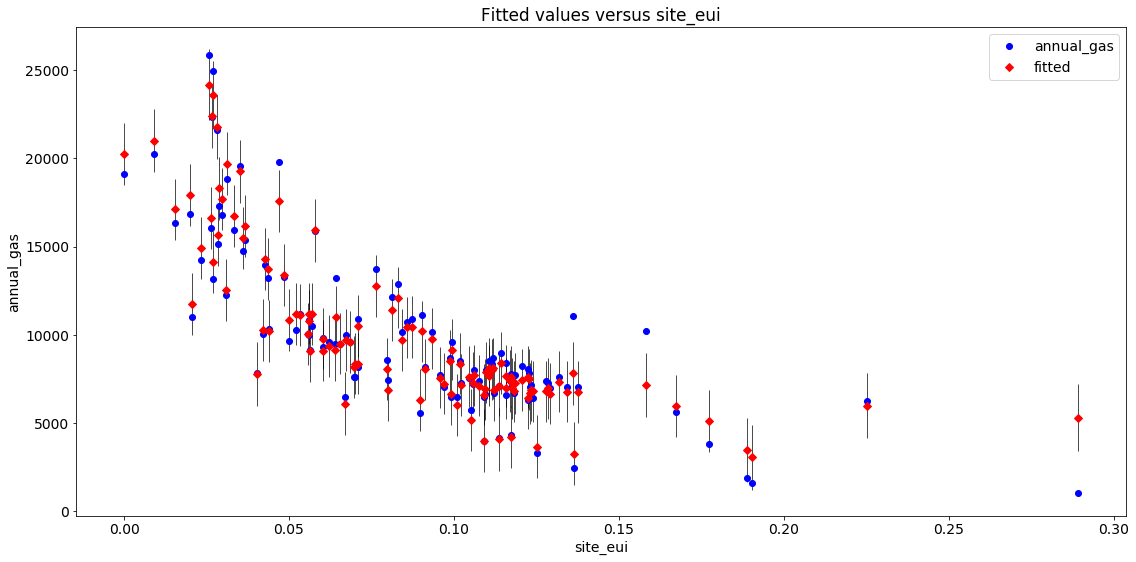

In [13]:
fig = sm.graphics.plot_fit(res_mfh, "site_eui")
fig.tight_layout(pad=1.0)

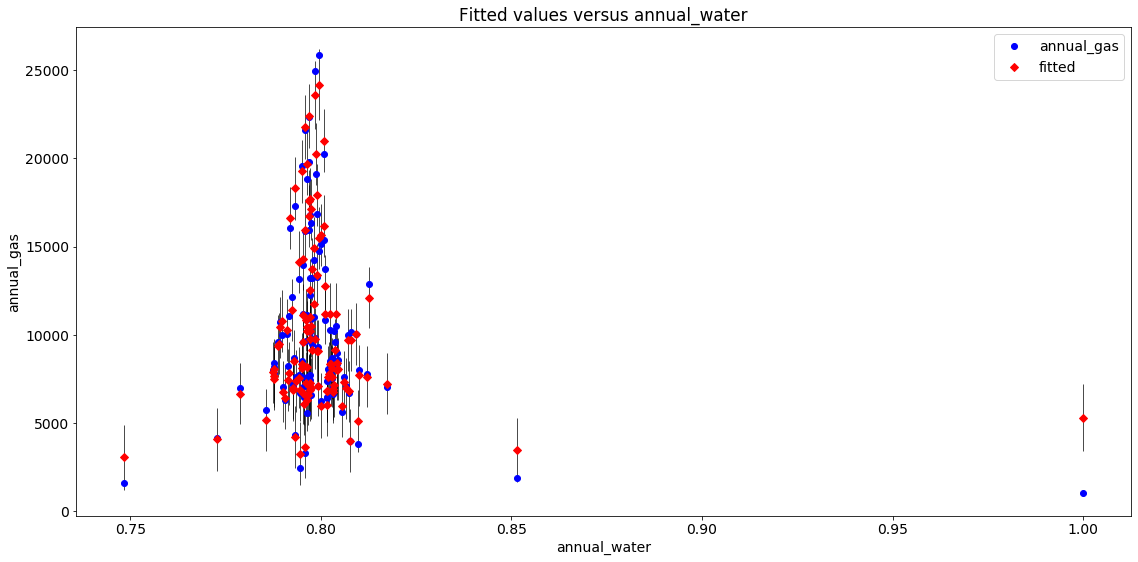

In [14]:
fig = sm.graphics.plot_fit(res_mfh, "annual_water")
fig.tight_layout(pad=1.0)

## EBEWE

In [15]:
EBEWE_buildings = pd.read_csv("Building_Data.csv") 
EBEWE_buildings = EBEWE_buildings.replace('Not Available',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace('',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace(' ',np.NaN)
display(EBEWE_buildings.head())

unique = EBEWE_buildings.drop_duplicates('BUILDING.ID') # unique builing IDs 

,Census.Tract.GEOID,BUILDING.ID,BUILDING.ADDRESS,CARBON.DIOXIDE.EMISSIONS,COMPLIANCE.STATUS,X.DIFFERENCE.SOURCE.EUI,X.DIFFERENCE.SITE.EUI,ENERGY.STAR.SCORE,ENERGY.STAR.CERTIFICATION.ELIGIBILITY,ENERGY.STAR.CERTIFICATION.LAST.APPROVAL.DATE,...,YEAR.BUILT,AIN,LADBS.Building.Category,CityOwned,Building.Wave,Longitude,Latitude,CES.Score,CES.Score.Percentile,Disadvantaged.Community
0,6.037101e+09,4.726490e+11,10655 TUJUNGA CANYON BLVD,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,25,"20,000 to 49,999",0,1,-118.29406,34.262585,22.670607,44.457056,0.0
1,6.037101e+09,4.746090e+11,10356 COMMERCE AVE,102.2,1,-11.2,-11.2,69.0,0.0,NaN,...,1983.0,81,"20,000 to 49,999",0,2,-118.28859,34.257057,22.670607,44.457056,0.0
2,6.037101e+09,4.726490e+11,10655 TUJUNGA CANYON BLVD,64.8,1,-43.6,-43.6,100.0,0.0,NaN,...,1982.0,25,"20,000 to 49,999",0,1,-118.29406,34.262585,22.670607,44.457056,0.0
3,6.037101e+09,4.706560e+11,7771 W FOOTHILL BLVD,34.3,1,-9.5,-9.5,NaN,0.0,NaN,...,1995.0,901,"7,500 to 14,999",1,3,-118.30181,34.258247,22.670607,44.457056,0.0
4,6.037101e+09,4.738340e+11,10304 TUJUNGA CANYON BLVD,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,57,"20,000 to 49,999",0,1,-118.29106,34.256090,22.670607,44.457056,0.0


In [16]:
unique["PROPERTY.TYPE"].unique()

array([nan, 'Multifamily Housing', 'Library', 'Retail Store',
       'Supermarket/Grocery Store', 'Office', 'Hotel',
       'Other - Recreation', 'Self-Storage Facility',
       'Non-Refrigerated Warehouse', 'Mixed Use Property',
       'Distribution Center', 'Manufacturing/Industrial Plant',
       'Automobile Dealership', 'Worship Facility', 'Fire Station',
       'Other', 'Repair Services (Vehicle, Shoe, Locksmith, etc.)',
       'Police Station', 'K-12 School', 'Refrigerated Warehouse',
       'Museum', 'Medical Office', 'Strip Mall',
       'Wholesale Club/Supercenter', 'Residential Care Facility',
       'Other - Public Services', 'Other - Services',
       'Hospital (General Medical & Surgical)', 'Senior Care Community',
       'Parking', 'Other - Utility', 'Movie Theater',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Roller Rink', 'Adult Education', 'Bank Branch',
       'Vocational School', 'Ice/Curling Rink', 'Laboratory',
       'Bar/Nightclub', 'C

In [17]:
# Select multi-family 
building_ss = unique[unique["PROPERTY.TYPE"].isin(["Multifamily Housing", 'Retail Store', 'Office'])]

building_ss.head()

,Census.Tract.GEOID,BUILDING.ID,BUILDING.ADDRESS,CARBON.DIOXIDE.EMISSIONS,COMPLIANCE.STATUS,X.DIFFERENCE.SOURCE.EUI,X.DIFFERENCE.SITE.EUI,ENERGY.STAR.SCORE,ENERGY.STAR.CERTIFICATION.ELIGIBILITY,ENERGY.STAR.CERTIFICATION.LAST.APPROVAL.DATE,...,YEAR.BUILT,AIN,LADBS.Building.Category,CityOwned,Building.Wave,Longitude,Latitude,CES.Score,CES.Score.Percentile,Disadvantaged.Community
1,6.037101e+09,4.746090e+11,10356 COMMERCE AVE,102.2,1,-11.2,-11.2,69.0,0.0,NaN,...,1983.0,81,"20,000 to 49,999",0,2,-118.288590,34.257057,22.670607,44.457056,0.0
5,6.037101e+09,4.710690e+11,7687 FOOTHILL BLVD,97.9,1,-17.1,-17.1,76.0,0.0,NaN,...,1981.0,17,"20,000 to 49,999",0,2,-118.299960,34.256470,22.670607,44.457056,0.0
32,6.037101e+09,4.751980e+11,10051 PINEWOOD AVE,76.3,1,-17.6,-17.6,81.0,0.0,NaN,...,1988.0,34,"20,000 to 49,999",0,1,-118.285934,34.251190,28.883657,57.598688,0.0
34,6.037101e+09,4.748810e+11,10230 SAMOA AVE,17.5,1,-58.0,-58.0,100.0,0.0,NaN,...,1978.0,47,"20,000 to 49,999",0,5,-118.287330,34.254684,28.883657,57.598688,0.0
42,6.037101e+09,4.733340e+11,10050 MOUNTAIR AVE,87.7,1,-12.2,-12.2,68.0,0.0,NaN,...,1964.0,25,"20,000 to 49,999",0,5,-118.293175,34.251842,28.883657,57.598688,0.0


In [18]:
# Renaming columns to match previous names
building_ss = building_ss.rename(columns={"YEAR.BUILT": "year_built", 
                                          "GROSS.BUILDING.FLOOR.AREA": "floor_area",
                                          "SITE.EUI": "site_eui",
                                          "TOTAL.WATER.USE": "annual_water",
                                         "PROPERTY.TYPE": "type"})


# Changing units
building_ss["annual_water"] = (building_ss["annual_water"]*1000)/building_ss['floor_area']
building_ss["floor_area"]

1        16526.0
5        42728.0
32       24769.0
34       21096.0
42       28901.0
          ...   
40278    32781.0
40522    29536.0
40547    41172.0
40579    25998.0
40592    48573.0
Name: floor_area, Length: 2537, dtype: float64

In [19]:
# Selecting regression x_variables
xvariables = building_ss[["BUILDING.ID", "year_built", "floor_area", "annual_water", "site_eui", "type"]]

# Add indicator variables as abvove
xvariables["post1980"] = 0
xvariables.loc[(xvariables['year_built'] >= 1980), 'post1980'] = 1

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables[["floor_area","site_eui","annual_water"]])
xvariables[["floor_area","site_eui","annual_water"]] = scaler.transform(xvariables[["floor_area","site_eui","annual_water"]])
xvariables = xvariables.drop(columns=["year_built"])
xvariables = xvariables.reset_index()
xvariables.head()

C:\Users\Nate\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Nate\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Nate\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,index,BUILDING.ID,floor_area,annual_water,site_eui,type,post1980
0,1,4.746090e+11,0.004551,0.002376,0.000361,Multifamily Housing,1
1,5,4.710690e+11,0.011813,0.001057,0.000282,Multifamily Housing,1
2,32,4.751980e+11,0.006835,0.001367,0.000382,Multifamily Housing,1
3,34,4.748810e+11,0.005817,0.000872,0.000087,Multifamily Housing,0
4,42,4.733340e+11,0.007981,0.001821,0.000366,Multifamily Housing,0


In [20]:
# Predicting # of HVAC Units
natural_gas = []

for i in range(len(xvariables)):
    if xvariables["type"].iloc[i] == 'Multifamily Housing':
        natural_gas = np.append(natural_gas, res_mfh.predict(xvariables.iloc[i:i+1]))
    elif xvariables["type"].iloc[i] == 'Office':
        natural_gas = np.append(natural_gas, res_off.predict(xvariables.iloc[i:i+1]))
    else:
        natural_gas = np.append(natural_gas, res_ret.predict(xvariables.iloc[i:i+1]))

In [21]:
xvariables["Natural Gas"] = pd.DataFrame(natural_gas)
xvariables[xvariables["type"] == "Office"].head(50)

,index,BUILDING.ID,floor_area,annual_water,site_eui,type,post1980,Natural Gas
9,103,4.774660e+11,0.009671,5.999915e-05,0.000149,Office,0,1114.466801
23,318,4.388010e+11,0.010311,2.928526e-04,0.000193,Office,1,1187.681060
43,1015,4.231620e+11,0.024831,1.267097e-04,0.000210,Office,1,2840.630401
45,1119,4.175670e+11,0.008200,3.698069e-04,0.000481,Office,1,944.004162
47,1323,4.199330e+11,0.012810,2.948492e-04,0.000339,Office,1,1473.144518
48,1350,4.194380e+11,0.007545,NaN,NaN,Office,1,NaN
49,1410,4.297520e+11,0.009472,6.794981e-05,0.000256,Office,1,1091.133957
52,1441,4.193470e+11,0.009465,1.666273e-04,0.000348,Office,1,1089.878932
53,1443,4.208850e+11,0.006167,3.748031e-04,0.000263,Office,1,711.126524
57,1565,4.097700e+11,0.023688,3.869131e-04,0.000128,Office,0,2711.754591


In [22]:

xvariables[["floor_area","site_eui","annual_water"]] = scaler.inverse_transform(xvariables[["floor_area","site_eui","annual_water"]])
xvariables.iloc[:50] 

,index,BUILDING.ID,floor_area,annual_water,site_eui,type,post1980,Natural Gas
0,1,4.746090e+11,16526.0,130.455041,48.9,Multifamily Housing,1,-512.661085
1,5,4.710690e+11,42728.0,58.053267,38.2,Multifamily Housing,1,361.025406
2,32,4.751980e+11,24769.0,75.081755,51.7,Multifamily Housing,1,-237.427718
3,34,4.748810e+11,21096.0,47.871634,11.8,Multifamily Housing,0,716.006713
4,42,4.733340e+11,28901.0,99.961939,49.5,Multifamily Housing,0,983.485368
5,52,4.746780e+11,21446.0,188.431409,NaN,Multifamily Housing,0,NaN
6,57,4.745130e+11,22796.0,63.265485,46.9,Multifamily Housing,1,-304.741646
7,65,4.767420e+11,27000.0,59.596296,11.6,Multifamily Housing,1,-165.702000
8,79,4.786700e+11,21456.0,19.211409,54.7,Retail Store,1,7435.956513
9,103,4.774660e+11,35000.0,3.294286,20.2,Office,0,1114.466801


(array([ 2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  2.,
         0.,  0., 13., 43.]),
 array([-115860.32918901, -111619.23381946, -107378.1384499 ,
        -103137.04308035,  -98895.9477108 ,  -94654.85234125,
         -90413.75697169,  -86172.66160214,  -81931.56623259,
         -77690.47086303,  -73449.37549348,  -69208.28012393,
         -64967.18475438,  -60726.08938482,  -56484.99401527,
         -52243.89864572,  -48002.80327617,  -43761.70790661,
         -39520.61253706,  -35279.51716751,  -31038.42179795,
         -26797.3264284 ,  -22556.23105885,  -18315.1356893 ,
         -14074.04031974,   -9832.94495019,   -5591.84958064,
          -1350.75421108,    2890.34115847,    7131.43652802,
          11372.53189757]),
 <a list of 30 Patch objects>)

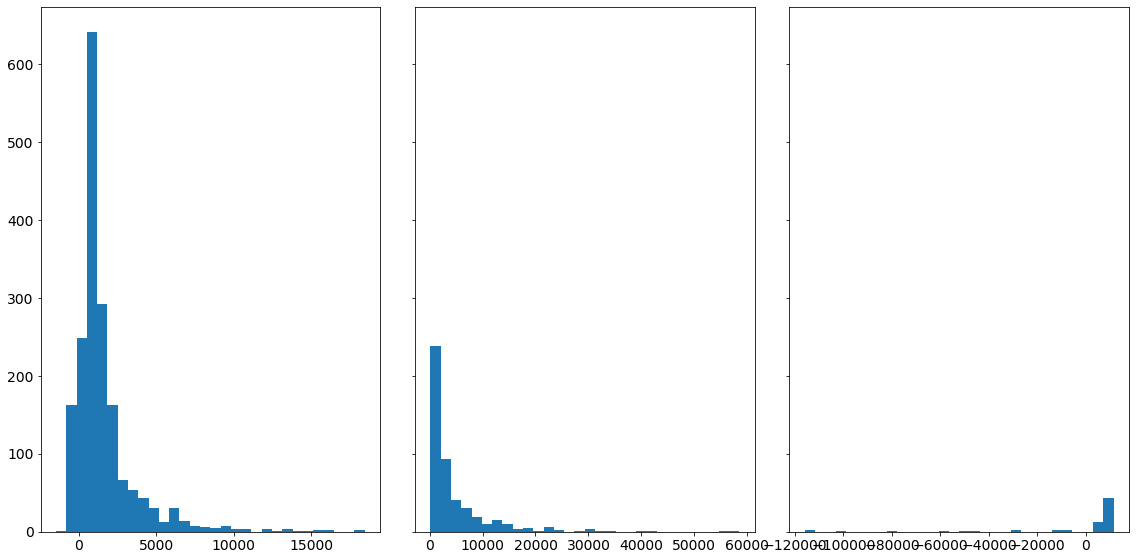

In [23]:
N_points = 100000
n_bins = 30

# Generate a normal distribution, center at x=0 and y=5
ng_mfh = xvariables[xvariables["type"] == "Multifamily Housing"]["Natural Gas"]
ng_off = xvariables[xvariables["type"] == "Office"]["Natural Gas"]
ng_ret = xvariables[xvariables["type"] == "Retail Store"]["Natural Gas"]

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(ng_mfh, bins=n_bins)
axs[1].hist(ng_off, bins=n_bins)
axs[2].hist(ng_ret, bins=n_bins)

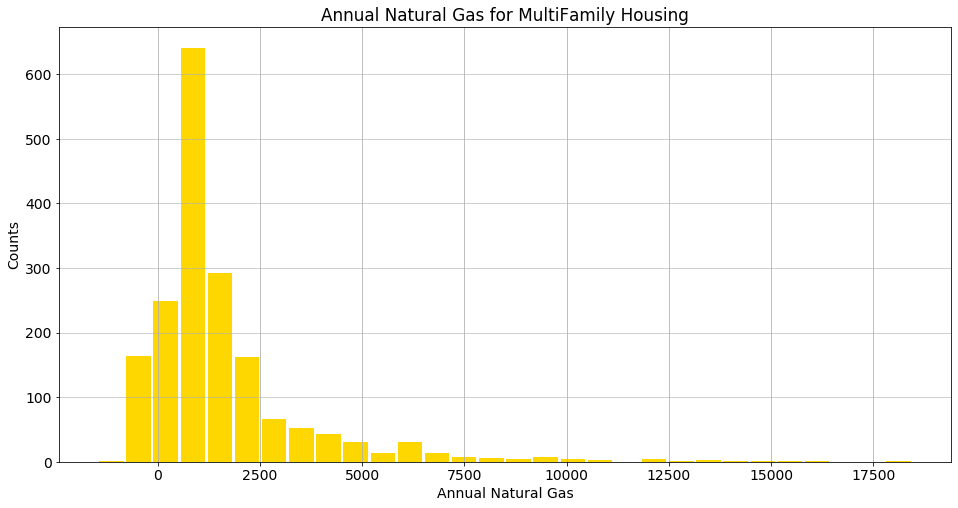

In [24]:
ng_mfh.plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='gold')
plt.title('Annual Natural Gas for MultiFamily Housing')
plt.xlabel('Annual Natural Gas')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

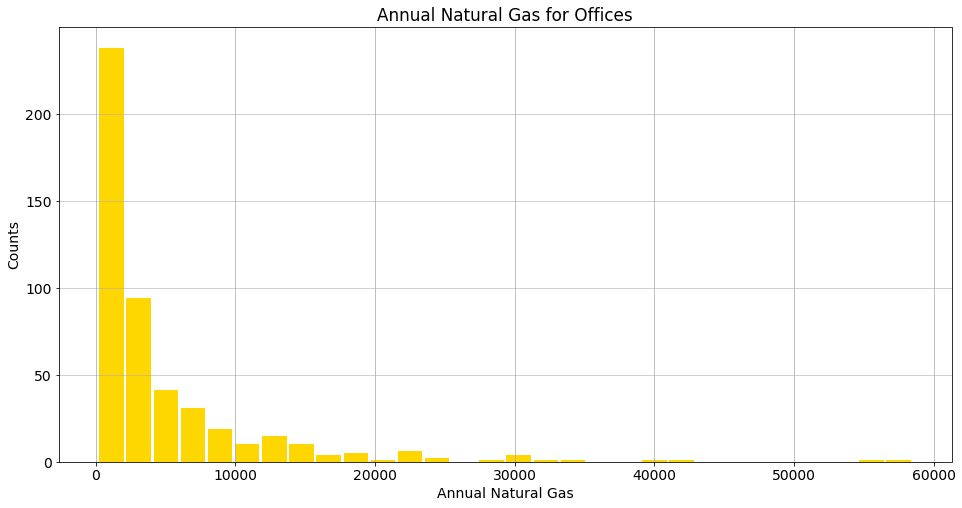

In [25]:
ng_off.plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='gold')
plt.title('Annual Natural Gas for Offices')
plt.xlabel('Annual Natural Gas')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

Text(0, 0.5, 'Annual Natural Gas')

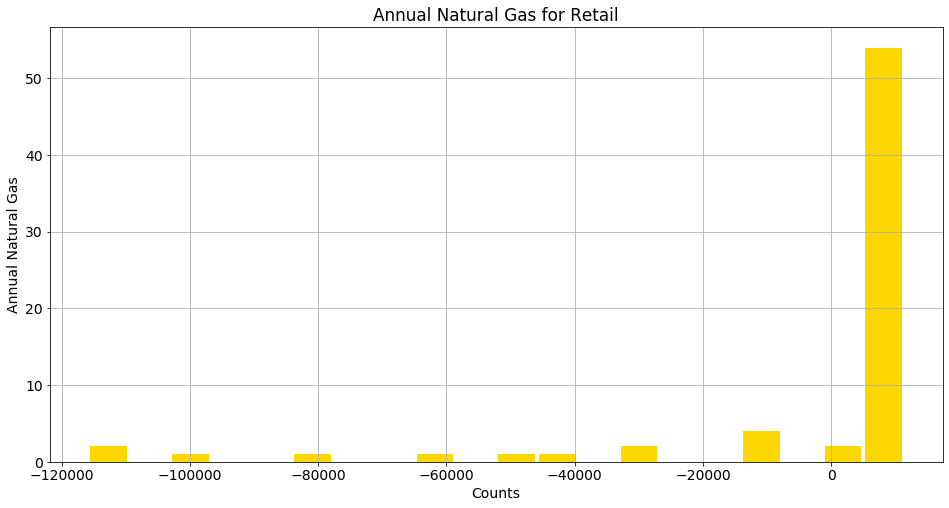

In [26]:
ng_ret.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='gold')
plt.title('Annual Natural Gas for Retail')
plt.xlabel('Counts')
plt.ylabel('Annual Natural Gas')

In [27]:
xvariables[xvariables["type"] == "Multifamily Housing"]["Natural Gas"]

0       -512.661085
1        361.025406
2       -237.427718
3        716.006713
4        983.485368
           ...     
2529    1394.151260
2531    -252.571088
2532    1108.449925
2533    1001.042818
2534    1395.208274
Name: Natural Gas, Length: 1947, dtype: float64

In [28]:
xvariables.to_csv("natural_gas_imputation.csv")

## KNN Imputation

In [29]:
#simdata = merged[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]
x_mfh = merged_mfh[["floor_area", "post1980", "site_eui", "annual_water"]]
x_off = merged_off[["floor_area", "post1980", "site_eui", "annual_water"]]
x_ret = merged_ret[["floor_area", "post1980", "site_eui", "annual_water"]]

y_mfh = merged_mfh["annual_gas"]
y_off = merged_off["annual_gas"]
y_ret = merged_ret["annual_gas"]

from sklearn.neighbors import KNeighborsRegressor

neigh_mfh = KNeighborsRegressor(n_neighbors=8)
neigh_off = KNeighborsRegressor(n_neighbors=8)
neigh_ret = KNeighborsRegressor(n_neighbors=8)

neigh_mfh.fit(x_mfh, y_mfh)
neigh_off.fit(x_off, y_off)
neigh_ret.fit(x_ret, y_ret)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                    weights='uniform')

In [35]:
xvariables2 = building_ss[["BUILDING.ID", "year_built", "floor_area", "annual_water", "site_eui", "type"]]
xvariables2 = xvariables2.dropna()
# Add indicator variables as abvove
xvariables2["post1980"] = 0
xvariables2.loc[(xvariables2['year_built'] >= 1980), 'post1980'] = 1

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables2[["floor_area","site_eui","annual_water"]])
xvariables2[["floor_area","site_eui","annual_water"]] = scaler.transform(xvariables2[["floor_area","site_eui","annual_water"]])
xvariables2 = xvariables2.drop(columns=["year_built"])
xvariables2 = xvariables2.reset_index()
xvariables2.head()

natural_gas_knn = []

for i in range(len(xvariables2)):
    if xvariables2["type"].iloc[i] == 'Multifamily Housing':
        natural_gas_knn = np.append(natural_gas_knn, neigh_mfh.predict(xvariables2[["floor_area", "post1980", "site_eui", "annual_water"]][i:i+1]))
    elif xvariables2["type"].iloc[i] == 'Retail Store':
        natural_gas_knn = np.append(natural_gas_knn, neigh_off.predict(xvariables2[["floor_area", "post1980", "site_eui", "annual_water"]][i:i+1]))
    else:
        natural_gas_knn = np.append(natural_gas_knn, neigh_ret.predict(xvariables2[["floor_area", "post1980", "site_eui", "annual_water"]][i:i+1]))

In [36]:
len(xvariables)

2537

In [37]:
xvariables2["KNN_Natural_Gas"] = natural_gas_knn
xvariables2.head()

,index,BUILDING.ID,floor_area,annual_water,site_eui,type,post1980,KNN_Natural_Gas
0,1,4.746090e+11,0.004551,0.002376,0.000361,Multifamily Housing,1,7385.546028
1,5,4.710690e+11,0.011813,0.001057,0.000282,Multifamily Housing,1,7385.546028
2,32,4.751980e+11,0.006835,0.001367,0.000382,Multifamily Housing,1,7385.546028
3,34,4.748810e+11,0.005817,0.000872,0.000087,Multifamily Housing,0,8691.796207
4,42,4.733340e+11,0.007981,0.001821,0.000366,Multifamily Housing,0,8691.796207


In [38]:
xvariables2["KNN_Natural_Gas"].unique()

array([ 7385.54602847,  8691.79620742,  1232.38426579,  3108.66079552,
        9232.30649473,  7741.69102666,  8938.63262799,   950.60020171,
        1232.75167915,  9706.18381624,  7741.69102666,  6480.85545573,
        9284.87857113, 12594.29211554, 10733.17556927,  8960.92373638,
        9676.54831635,  9099.4486642 , 17057.12053128,  9099.4486642 ,
        9272.49896816,  7912.06499184,  6967.12260714,  7611.17356296,
       10376.53207007, 11651.63439256, 13378.8743714 , 18957.02284445,
       11437.79293939,  9272.71562607, 10173.25409468,  9390.49309635,
       10733.17556927,  5268.85798397])